In [1]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import ants
from tqdm import tqdm

In [2]:
def correlate_columns(arr1, arr2):
    """
    Computes the Pearson correlation between corresponding columns of two matrices.
    
    Parameters:
    arr1 (np.ndarray): First matrix of shape (370, 1000)
    arr2 (np.ndarray): Second matrix of shape (370, 1000)
    
    Returns:
    np.ndarray: 1D array of correlations for each column (size 1000)
    """
    # Ensure input arrays are numpy arrays
    arr1 = np.asarray(arr1)
    arr2 = np.asarray(arr2)
    
    # Subtract the mean of each column (normalize)
    arr1_centered = arr1 - np.mean(arr1, axis=0)
    arr2_centered = arr2 - np.mean(arr2, axis=0)
    
    # Compute the numerator (covariance)
    numerator = np.sum(arr1_centered * arr2_centered, axis=0)
    
    # Compute the denominator (product of standard deviations)
    denominator = np.sqrt(np.sum(arr1_centered**2, axis=0) * np.sum(arr2_centered**2, axis=0))
    
    # Compute the Pearson correlation for each column
    correlation = numerator / denominator
    
    return correlation

In [3]:
def get_regs(events_fn):
    from nilearn.glm.first_level import make_first_level_design_matrix

    events = pd.read_csv(events_fn,delimiter='\t')

    t_r = 0.8
    n_scans = nTR
    frame_times = (np.arange(n_scans) * t_r)
    X1 = make_first_level_design_matrix(frame_times,events,drift_model="polynomial",drift_order=3,hrf_model="SPM") #
    face_reg = X1[['0_back_negface','0_back_neutface','0_back_posface','2_back_negface','2_back_neutface','2_back_posface']].values.sum(axis=1)
    place_reg = X1[['0_back_place','2_back_place']].values.sum(axis=1)

    return face_reg,place_reg

In [4]:
def get_contrast_val(Y,return_type='contrast',contrast_name='face'):
    from nilearn.glm.first_level import make_first_level_design_matrix
    
    events = pd.read_csv(events_fn,delimiter='\t')

    t_r = 0.8
    n_scans = Y.shape[1]
    frame_times = (np.arange(n_scans) * t_r)

    X1 = make_first_level_design_matrix(frame_times,events,drift_model="polynomial",drift_order=3,hrf_model="SPM") #

    Y = (Y-Y.mean(axis=1)[:,np.newaxis])/Y.std(axis=1)[:,np.newaxis] # Z score values
    Y = Y.transpose()
    X = X1.values
    beta = np.linalg.inv(X.T @ X1) @ X1.T @ Y
    beta = beta.T
    beta = beta.values

    if contrast_name=='face':
        contrast_vector = np.array([1,1,-3,1,1,1,-3,1,0,0,0,0,0,0]) # Faces > Place
    elif contrast_name=='place':
        contrast_vector = np.array([-1,-1,3,-1,-1,-1,3,-1,0,0,0,0,0,0]) # Place > Face
    
    contrast_values = beta @ contrast_vector

    if return_type=='contrast':
        #return contrast_values.mean()
        return contrast_values
    elif return_type=='betas':
        return beta.mean(axis=0)

In [5]:
indir = '../Data/020-fmriprepped'
subs = [s for s in os.listdir(indir) if all((s.startswith('sub'),not s.endswith('.html')))]
subs.sort()
print(len(subs))

34


In [6]:
analysis_name = 'DeepCor-ABCD-v5'
analysis_dir = os.path.join('../Data/StudyForrest/ensembles_last_CVAE/',analysis_name)

In [7]:
events_fn_temp = '../Data/011-ABCD-events/{sub}_ses-baselineYear1Arm1_task-nback_run-0{r}_events.tsv'

In [8]:
ofname = os.path.join(analysis_dir,'{name}_S{s}_R{r}_med.nii.gz')

In [9]:
svec = np.random.permutation(np.arange(len(subs)))
rvec = np.random.permutation([1,2])

svec = np.arange(len(subs))
rvec = [1,2]

In [36]:
epi_fn

'../Data/StudyForrest/ensembles_last_CVAE/DeepCor-ABCD-v5/signal_S33_R2_med.nii.gz'

<AxesSubplot:>

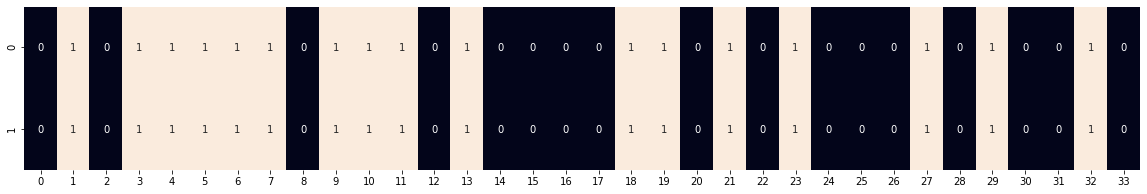

In [37]:
check_done = np.zeros((len(svec),len(rvec)))
for s in svec:
    for r in rvec:
        epi_fn = os.path.join(analysis_dir,f'signal_S{s}_R{r}_med.nii.gz')
        check_done[s,r-1]=np.array(os.path.exists(epi_fn.format(s=s,r=r)))*1.0

import seaborn as sns
plt.figure(figsize=(20,3))
sns.heatmap(check_done.transpose(),annot=True,cbar=False,vmin=0,vmax=1)

In [19]:
delete_old = True
if delete_old==True:
    for s in svec:
        for r in rvec:
            file_path = ofname.format(name='corr2face',s=s,r=r); os.remove(file_path) if os.path.exists(file_path) else None
            file_path = ofname.format(name='corr2place',s=s,r=r); os.remove(file_path) if os.path.exists(file_path) else None
            file_path = ofname.format(name='contrast_face',s=s,r=r); os.remove(file_path) if os.path.exists(file_path) else None
            file_path = ofname.format(name='contrast_place',s=s,r=r); os.remove(file_path) if os.path.exists(file_path) else None

In [30]:
for s in tqdm(svec):
    sub = subs[s]
    for r in tqdm(rvec,leave=False):
    
        is_done = all([os.path.exists(ofname.format(name='corr2face',s=s,r=r)),
    os.path.exists(ofname.format(name='corr2place',s=s,r=r)),
    os.path.exists(ofname.format(name='contrast_face',s=s,r=r)),
    os.path.exists(ofname.format(name='contrast_place',s=s,r=r)),])
        
        if is_done==False:
            anat_fn = os.path.join(indir,sub,'ses-baselineYear1Arm1','anat',f'{sub}_ses-baselineYear1Arm1_run-01_space-MNI152NLin2009cAsym_res-2_desc-preproc_T1w.nii.gz')
            anat_gm_fn = os.path.join(indir,sub,'ses-baselineYear1Arm1','anat',f'{sub}_ses-baselineYear1Arm1_run-01_space-MNI152NLin2009cAsym_res-2_label-GM_probseg.nii.gz')
            anat_wm_fn = os.path.join(indir,sub,'ses-baselineYear1Arm1','anat',f'{sub}_ses-baselineYear1Arm1_run-01_space-MNI152NLin2009cAsym_res-2_label-WM_probseg.nii.gz')
            anat_csf_fn = os.path.join(indir,sub,'ses-baselineYear1Arm1','anat',f'{sub}_ses-baselineYear1Arm1_run-01_space-MNI152NLin2009cAsym_res-2_label-CSF_probseg.nii.gz')

            epi_fn = os.path.join(analysis_dir,f'signal_S{s}_R{r}_med.nii.gz')
            if os.path.exists(epi_fn):
                epi = ants.image_read(epi_fn)
                nTR = epi.shape[-1]

                events_fn = events_fn_temp.format(sub=subs[s],r=r)
                face_reg,place_reg = get_regs(events_fn)

                #anat = ants.image_read(anat_fn)
                gm = ants.image_read(anat_gm_fn)
                wm = ants.image_read(anat_wm_fn)
                csf = ants.image_read(anat_csf_fn)

                gm_values = gm.numpy()
                gm_mask = (gm_values>0.5)
                wm_values = wm.numpy()
                csf_values = csf.numpy()
                cf_values = wm_values+csf_values
                cf_mask = (cf_values>0.5)

                diff = gm_mask & cf_mask
                gm_mask_c = gm_mask ^ diff
                cf_mask_c = cf_mask ^ diff
                gm_mask_c = gm_mask_c*(epi.numpy().std(axis=-1)>1e-3) # Drop std0

                ndummy = 8 # how many dummy scans to discard

                epi_flat = epi.numpy().reshape(-1,nTR).transpose() 
                epi_flat[0:ndummy,:] = epi_flat[ndummy+1::,:].mean(axis=0) # What to do with dummy scans, set to mean
                epi_flat = epi_flat.transpose()

                gm_flat = gm_mask_c.flatten().astype(int)
                cf_flat = cf_mask_c.flatten().astype(int)


                func_gm = epi_flat[gm_flat==1,:].copy() # Data that will be used as the ROI data
                func_cf = epi_flat[cf_flat==1,:].copy() # Data that will be used as the RONI data

                reg = face_reg
                r_vals = correlate_columns(func_gm.transpose(),np.tile(reg[:,np.newaxis],func_gm.shape[0]))
                new_arr = np.zeros(gm.shape)
                new_arr[gm_mask_c==True]=r_vals
                new_im = gm.new_image_like(new_arr)
                ofn = ofname.format(name='corr2face',s=s,r=r)
                new_im.to_filename(ofn)

                reg = place_reg
                r_vals = correlate_columns(func_gm.transpose(),np.tile(reg[:,np.newaxis],func_gm.shape[0]))
                new_arr = np.zeros(gm.shape)
                new_arr[gm_mask_c==True]=r_vals
                new_im = gm.new_image_like(new_arr)
                ofn = ofname.format(name='corr2place',s=s,r=r)
                new_im.to_filename(ofn)

                con_vals = get_contrast_val(func_gm,return_type='contrast',contrast_name='face')
                new_arr = np.zeros(gm.shape)
                new_arr[gm_mask_c==True]=con_vals
                new_im = gm.new_image_like(new_arr)
                ofn = ofname.format(name='contrast_face',s=s,r=r)
                new_im.to_filename(ofn)

                con_vals = get_contrast_val(func_gm,return_type='contrast',contrast_name='place')
                new_arr = np.zeros(gm.shape)
                new_arr[gm_mask_c==True]=con_vals
                new_im = gm.new_image_like(new_arr)
                ofn = ofname.format(name='contrast_place',s=s,r=r)
                new_im.to_filename(ofn)

  0%|          | 0/2 [00:00<?, ?it/s]
                                     
  0%|          | 0/2 [00:00<?, ?it/s]
                                     
  0%|          | 0/2 [00:00<?, ?it/s]
                                     
  0%|          | 0/2 [00:00<?, ?it/s]
                                     
  0%|          | 0/2 [00:00<?, ?it/s]
                                     
  0%|          | 0/2 [00:00<?, ?it/s]
                                     
  0%|          | 0/2 [00:00<?, ?it/s]
                                     
  0%|          | 0/2 [00:00<?, ?it/s]
                                     
  0%|          | 0/2 [00:00<?, ?it/s]
                                     
  0%|          | 0/2 [00:00<?, ?it/s]
                                     
  0%|          | 0/2 [00:00<?, ?it/s]
                                     
  0%|          | 0/2 [00:00<?, ?it/s]
                                     
  0%|          | 0/2 [00:00<?, ?it/s]
                                     
  0%|       

<AxesSubplot:>

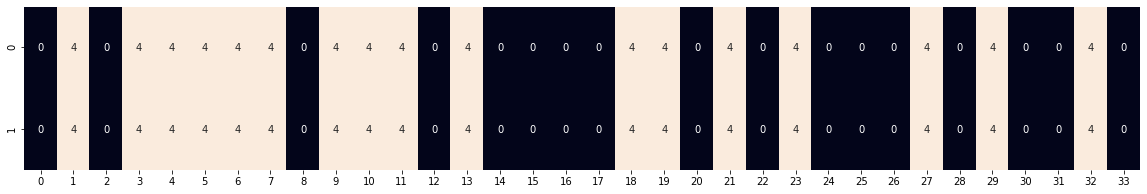

In [31]:
check_done = np.zeros((len(svec),len(rvec)))
for s in svec:
    for r in rvec:
        is_done = [os.path.exists(ofname.format(name='corr2face',s=s,r=r)),
    os.path.exists(ofname.format(name='corr2place',s=s,r=r)),
    os.path.exists(ofname.format(name='contrast_face',s=s,r=r)),
    os.path.exists(ofname.format(name='contrast_place',s=s,r=r))]
        check_done[s,r-1]=np.array(is_done).sum()

import seaborn as sns
plt.figure(figsize=(20,3))
sns.heatmap(check_done.transpose(),annot=True,cbar=False)